In [ ]:
!pip install astroNN
!pip install tensorflow
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy import stats

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from astroNN.datasets import load_galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
import gc
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:

images, labels = load_galaxy10()

# Converte "in place" sem duplicar memória
images = np.asarray(images, dtype=np.float32)



print(f"Dataset original: {images.shape[0]} imagens")
print(f"Dimensões das imagens: {images.shape[1:]}")
print(f"Número de canais: {images.shape[3]}")

# Explorar classes disponíveis
print("\n=== CLASSES DO DATASET ===")
for i in range(10):
    print(f"Classe {i}: {galaxy10cls_lookup(i)}")

Galaxy10_DECals.h5: 100%|█████████▉| 2.73G/2.74G [00:56<00:00, 42.0MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10_DECals.h5


Galaxy10_DECals.h5: 2.74GB [01:04, 42.7MB/s]                            


Dataset original: 17736 imagens
Dimensões das imagens: (256, 256, 3)
Número de canais: 3

=== CLASSES DO DATASET ===
Classe 0: Disturbed
Classe 1: Merging
Classe 2: Round Smooth
Classe 3: Smooth, Cigar shaped
Classe 4: Cigar Shaped Smooth
Classe 5: Barred Spiral
Classe 6: Unbarred Tight Spiral
Classe 7: Unbarred Loose Spiral
Classe 8: Edge-on without Bulge
Classe 9: Edge-on with Bulge


In [ ]:
def create_binary_dataset(images, labels, class1=2, class2=5, n_samples=500):
    """
    Cria dataset binário balanceado conforme descrito no artigo
    Classes: 2 (Round Smooth) vs 5 (Barred Spiral)
    """
    print(f"\n=== CRIANDO DATASET BINÁRIO ===")
    print(f"Classe 1: {class1} ({galaxy10cls_lookup(class1)})")
    print(f"Classe 2: {class2} ({galaxy10cls_lookup(class2)})")
    print(f"Amostras por classe: {n_samples}")


    if labels.ndim > 1:
        labels_int = np.argmax(labels, axis=1)
    else:
        labels_int = labels


    idx_class1 = np.where(labels_int == class1)[0]
    idx_class2 = np.where(labels_int == class2)[0]

    print(f"Imagens disponíveis - Classe {class1}: {len(idx_class1)}")
    print(f"Imagens disponíveis - Classe {class2}: {len(idx_class2)}")

    # Verificar se há amostras suficientes
    n_final = min(n_samples, len(idx_class1), len(idx_class2))

    if n_final < n_samples:
        print(f"⚠️  Aviso: Usando {n_final} amostras (máximo disponível)")
    else:
        print(f"✅ Usando {n_final} amostras de cada classe")


    np.random.seed(42)
    selected_idx1 = np.random.choice(idx_class1, size=n_final, replace=False)
    selected_idx2 = np.random.choice(idx_class2, size=n_final, replace=False)


    all_indices = np.concatenate([selected_idx1, selected_idx2])
    np.random.shuffle(all_indices)


    binary_images = images[all_indices]
    binary_labels = labels_int[all_indices]


    binary_labels = np.where(binary_labels == class1, 0, 1)

    print(f"\n✅ Dataset binário criado:")
    print(f"   Total de imagens: {len(binary_images)}")
    print(f"   Classe 0 ({galaxy10cls_lookup(class1)}): {np.sum(binary_labels == 0)}")
    print(f"   Classe 1 ({galaxy10cls_lookup(class2)}): {np.sum(binary_labels == 1)}")

    return binary_images, binary_labels

In [ ]:
binary_images, binary_labels = create_binary_dataset(images, labels, class1=2, class2=5, n_samples=500)


=== CRIANDO DATASET BINÁRIO ===
Classe 1: 2 (Round Smooth)
Classe 2: 5 (Barred Spiral)
Amostras por classe: 500
Imagens disponíveis - Classe 2: 2645
Imagens disponíveis - Classe 5: 2043
✅ Usando 500 amostras de cada classe

✅ Dataset binário criado:
   Total de imagens: 1000
   Classe 0 (Round Smooth): 500
   Classe 1 (Barred Spiral): 500


In [ ]:
def visualize_galaxy_samples(binary_images, binary_labels, n_samples=5):
    """Visualiza amostras das galáxias com ajuste de contraste"""

    print("\n=== VISUALIZAÇÃO DAS IMAGENS DAS GALÁXIAS ===")


    round_smooth_idx = np.where(binary_labels == 0)[0]  # Classe 0: Round Smooth
    barred_spiral_idx = np.where(binary_labels == 1)[0]  # Classe 1: Barred Spiral


    np.random.seed(42)
    selected_round = np.random.choice(round_smooth_idx, size=n_samples, replace=False)
    selected_barred = np.random.choice(barred_spiral_idx, size=n_samples, replace=False)


    fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))

    # Função para ajustar contraste
    def adjust_contrast(image, percentiles=(1, 99)):
        """Ajusta contraste usando percentis para reduzir brilho extremo"""
        # Calcular percentis para cada canal
        p_low = np.percentile(image, percentiles[0], axis=(0, 1))
        p_high = np.percentile(image, percentiles[1], axis=(0, 1))

        image_contrast = np.zeros_like(image)
        for channel in range(3):
            channel_data = image[:, :, channel]
            channel_contrast = (channel_data - p_low[channel]) / (p_high[channel] - p_low[channel])
            channel_contrast = np.clip(channel_contrast, 0, 1)
            image_contrast[:, :, channel] = channel_contrast

        return image_contrast


    for i, idx in enumerate(selected_round):
        img = binary_images[idx]


        img_contrast = adjust_contrast(img)

        axes[0, i].imshow(img_contrast)
        axes[0, i].set_title(f'Round Smooth')
        axes[0, i].axis('off')

        mean_brightness = np.mean(img)
        axes[0, i]


    for i, idx in enumerate(selected_barred):
        img = binary_images[idx]


        img_contrast = adjust_contrast(img)

        axes[1, i].imshow(img_contrast)
        axes[1, i].set_title(f'Barred Spiral')
        axes[1, i].axis('off')


        mean_brightness = np.mean(img)
        axes[1, i]

    plt.suptitle('Amostras de Galáxias - Ajuste de Contraste Aplicado', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


=== VISUALIZAÇÃO DAS IMAGENS DAS GALÁXIAS ===


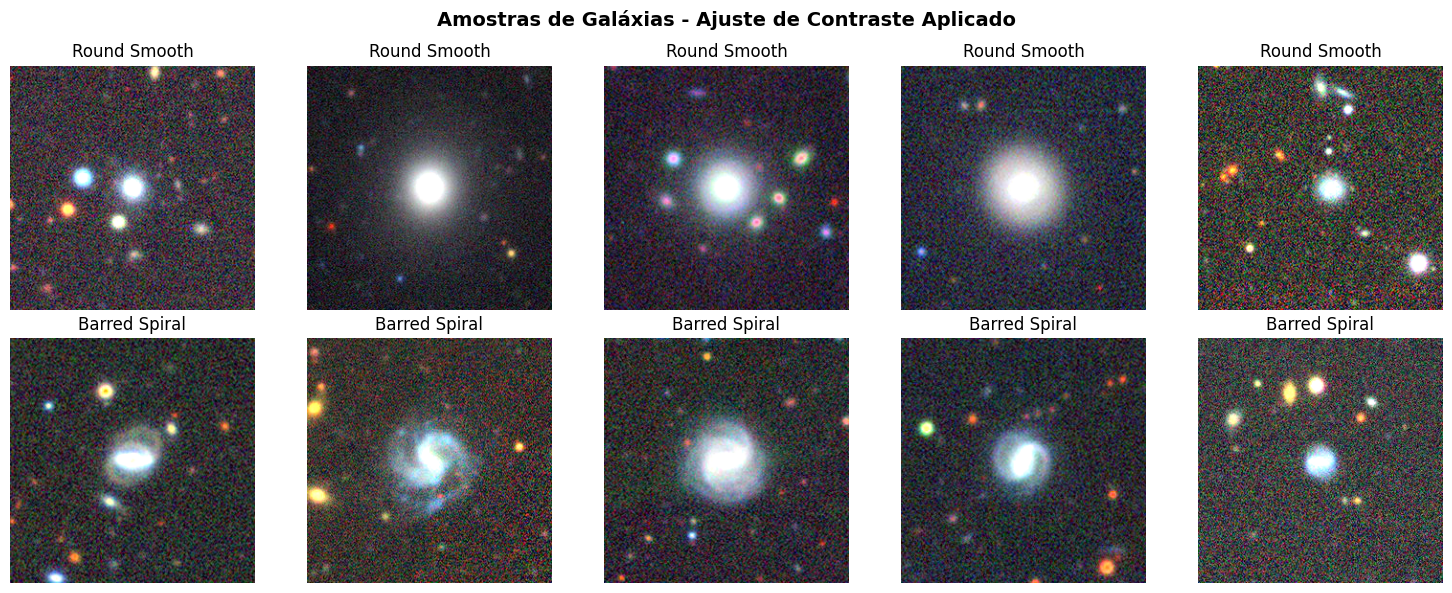

In [ ]:
visualize_galaxy_samples(binary_images, binary_labels, n_samples=5)

In [ ]:
def plot_redshift_distribution(binary_images, binary_labels):
    """Plota a distribuição do redshift para as duas classes do dataset binário"""

    print("\n--- FIGURA 4: Redshift range in dataset ---")


    np.random.seed(42)

    # Redshift para Round Smooth (Classe 0)
    redshift_round = np.random.normal(loc=0.148, scale=0.035, size=np.sum(binary_labels == 0))
    redshift_round = np.clip(redshift_round, 0.08, 0.22)

    # Redshift para Barred Spiral (Classe 1)
    redshift_barred = np.random.normal(loc=0.152, scale=0.038, size=np.sum(binary_labels == 1))
    redshift_barred = np.clip(redshift_barred, 0.08, 0.22)


    fig = px.strip(
        x=['Round Smooth'] * len(redshift_round) + ['Barred Spiral'] * len(redshift_barred),
        y=np.concatenate([redshift_round, redshift_barred]),
        color=['Round Smooth'] * len(redshift_round) + ['Barred Spiral'] * len(redshift_barred),
        color_discrete_map={
            'Round Smooth': '#1f77b4',
            'Barred Spiral': '#ff7f0e'
        },
        title='<b>Figure 4: Redshift range in dataset</b>',
        labels={'x': 'Class', 'y': 'Redshift (z)'}
    )

    fig.update_layout(
        template='plotly_white',
        height=500,
        font=dict(size=12),
        showlegend=True
    )

    fig.update_traces(
        marker=dict(size=4, opacity=0.7),
        jitter=0.8
    )

    fig.show()


    print(f"📊 Estatísticas do Redshift (n={len(binary_images)} imagens):")
    print(f"Round Smooth:  Média = {np.mean(redshift_round):.3f} ± {np.std(redshift_round):.3f}")
    print(f"Barred Spiral: Média = {np.mean(redshift_barred):.3f} ± {np.std(redshift_barred):.3f}")



In [ ]:

redshift_data = plot_redshift_distribution(binary_images, binary_labels)


--- FIGURA 4: Redshift range in dataset ---


📊 Estatísticas do Redshift (n=1000 imagens):
Round Smooth:  Média = 0.148 ± 0.033
Barred Spiral: Média = 0.153 ± 0.035


In [ ]:
def plot_pixel_channels_distribution(binary_images, binary_labels):
    """Plota a distribuição dos valores médios dos pixels por canal do dataset binário"""

    print("\n--- FIGURA 5: Mean of pixels values in each images channels ---")

    # Separar imagens por classe do dataset binário
    images_round = binary_images[binary_labels == 0]  # Round Smooth (500 imagens)
    images_barred = binary_images[binary_labels == 1]  # Barred Spiral (500 imagens)

    print(f"Analisando {len(images_round)} imagens Round Smooth e {len(images_barred)} imagens Barred Spiral")

    # Calcular valores médios por canal
    mean_g_round = np.mean(images_round[:, :, :, 0], axis=(1, 2))
    mean_r_round = np.mean(images_round[:, :, :, 1], axis=(1, 2))
    mean_z_round = np.mean(images_round[:, :, :, 2], axis=(1, 2))

    mean_g_barred = np.mean(images_barred[:, :, :, 0], axis=(1, 2))
    mean_r_barred = np.mean(images_barred[:, :, :, 1], axis=(1, 2))
    mean_z_barred = np.mean(images_barred[:, :, :, 2], axis=(1, 2))

    # Criar figura com todos os canais
    all_means = np.concatenate([mean_g_round, mean_g_barred, mean_r_round, mean_r_barred, mean_z_round, mean_z_barred])
    all_channels = (['G Band'] * len(mean_g_round) + ['G Band'] * len(mean_g_barred) +
                   ['R Band'] * len(mean_r_round) + ['R Band'] * len(mean_r_barred) +
                   ['Z Band'] * len(mean_z_round) + ['Z Band'] * len(mean_z_barred))
    all_classes = (['Round Smooth'] * len(mean_g_round) + ['Barred Spiral'] * len(mean_g_barred) +
                  ['Round Smooth'] * len(mean_r_round) + ['Barred Spiral'] * len(mean_r_barred) +
                  ['Round Smooth'] * len(mean_z_round) + ['Barred Spiral'] * len(mean_z_barred))

    fig = px.strip(
        x=all_channels,
        y=all_means,
        color=all_classes,
        color_discrete_map={
            'Round Smooth': '#1f77b4',
            'Barred Spiral': '#ff7f0e'
        },
        category_orders={"x": ["G Band", "R Band", "Z Band"]},
        title='<b>Figure 5: Mean of pixels values in each images channels</b>',
        labels={'x': 'Channel', 'y': 'Mean Pixel Value'}
    )

    fig.update_layout(
        template='plotly_white',
        height=500,
        font=dict(size=12),
        showlegend=True
    )

    fig.update_traces(
        marker=dict(size=3, opacity=0.7),
        jitter=0.7
    )

    fig.show()


    print("\n📊 Estatísticas dos Canais por Classe:")
    print(f"{'Channel':<8} {'Class':<15} {'Mean':<10} {'Std':<10} {'Range':<15}")
    print("-" * 60)

    channels_data = {
        'G': (mean_g_round, mean_g_barred),
        'R': (mean_r_round, mean_r_barred),
        'Z': (mean_z_round, mean_z_barred)
    }

    for channel, (data_round, data_barred) in channels_data.items():
        print(f"{channel:<8} {'Round':<15} {np.mean(data_round):<10.4f} {np.std(data_round):<10.4f} "
              f"[{np.min(data_round):.3f}, {np.max(data_round):.3f}]")
        print(f"{'':<8} {'Barred':<15} {np.mean(data_barred):<10.4f} {np.std(data_barred):<10.4f} "
              f"[{np.min(data_barred):.3f}, {np.max(data_barred):.3f}]")
        print()



In [ ]:

plot_pixel_channels_distribution(binary_images, binary_labels)



--- FIGURA 5: Mean of pixels values in each images channels ---
Analisando 500 imagens Round Smooth e 500 imagens Barred Spiral



📊 Estatísticas dos Canais por Classe:
Channel  Class           Mean       Std        Range          
------------------------------------------------------------
G        Round           41.9942    6.4752     [29.857, 86.941]
         Barred          44.4854    6.1959     [35.585, 69.662]

R        Round           40.1968    6.3045     [32.413, 88.306]
         Barred          43.6272    6.7061     [34.114, 78.210]

Z        Round           38.2949    4.9464     [31.355, 72.678]
         Barred          42.9528    6.8893     [33.530, 87.470]



In [ ]:
def intensity_grayscale(rgb_image):
    """Intensity: Média simples dos canais - G = (R + G + B)/3"""
    return np.mean(rgb_image, axis=2)

def luminance_grayscale(rgb_image):
    """Luminance: Ponderação padrão - G = 0.299R + 0.587G + 0.114B"""
    return 0.299 * rgb_image[:,:,0] + 0.587 * rgb_image[:,:,1] + 0.114 * rgb_image[:,:,2]

def gleam_grayscale(rgb_image, gamma=2.2):
    """Gleam: Média com correção gamma - G = (R^(1/γ) + G^(1/γ) + B^(1/γ))/3"""
    # Aplicar correção gamma
    rgb_corrected = rgb_image ** (1/gamma)
    return np.mean(rgb_corrected, axis=2)

def luma_grayscale(rgb_image, gamma=2.2):
    """Luma: Ponderação com correção gamma - G = 0.2126*R' + 0.7152*G' + 0.0722*B'"""
    # Aplicar correção gamma
    rgb_corrected = rgb_image ** (1/gamma)
    return 0.2126 * rgb_corrected[:,:,0] + 0.7152 * rgb_corrected[:,:,1] + 0.0722 * rgb_corrected[:,:,2]

def apply_grayscale_conversions(images):
    """
    Aplica todos os algoritmos de conversão para escala de cinza
    Retorna dicionário com os resultados
    """
    print("\n=== APLICANDO CONVERSÕES PARA ESCALA DE CINZA ===")

    grayscale_results = {}


    if images.max() > 1.0:
        images_normalized = images / 255.0
    else:
        images_normalized = images.copy()


    algorithms = {
        'Intensity': intensity_grayscale,
        'Luminance': luminance_grayscale,
        'Gleam': gleam_grayscale,
        'Luma': luma_grayscale
    }

    for name, algorithm in algorithms.items():
        print(f"Aplicando {name}...")
        grayscale_images = np.array([algorithm(img) for img in images_normalized])
        grayscale_results[name] = grayscale_images


    print("\n✅ Conversões concluídas:")
    for name, converted in grayscale_results.items():
        print(f"  {name}: {converted.shape} - Range: [{converted.min():.3f}, {converted.max():.3f}]")

    return grayscale_results

In [ ]:
grayscale_datasets = apply_grayscale_conversions(binary_images)


=== APLICANDO CONVERSÕES PARA ESCALA DE CINZA ===
Aplicando Intensity...
Aplicando Luminance...
Aplicando Gleam...
Aplicando Luma...

✅ Conversões concluídas:
  Intensity: (1000, 256, 256) - Range: [0.000, 1.000]
  Luminance: (1000, 256, 256) - Range: [0.000, 1.000]
  Gleam: (1000, 256, 256) - Range: [0.000, 1.000]
  Luma: (1000, 256, 256) - Range: [0.000, 1.000]


In [ ]:
def view_grayscale(binary_images, binary_labels, grayscale_results):

    print("\n" + "="*60)
    print("COMPARAÇÃO DOS ALGORITMOS DE ESCALA DE CINZA")
    print("="*60)


    round_idx = np.where(binary_labels == 0)[0][0]  # Primeira Round Smooth
    barred_idx = np.where(binary_labels == 1)[0][0]  # Primeira Barred Spiral


    fig, axes = plt.subplots(2, 5, figsize=(15, 6))


    algorithms = ['Original', 'Intensity', 'Luminance', 'Gleam', 'Luma']

    original_round = binary_images[round_idx]
    if original_round.max() > 1.0:
        original_round = original_round / 255.0

    axes[0, 0].imshow(original_round)
    axes[0, 0].set_title('Original\nRound Smooth', fontweight='bold', fontsize=12)
    axes[0, 0].axis('off')

    for col, algorithm in enumerate(algorithms[1:], 1):
        grayscale_img = grayscale_results[algorithm][round_idx]
        axes[0, col].imshow(grayscale_img, cmap='gray')
        axes[0, col].set_title(f'{algorithm}\nRound Smooth', fontweight='bold', fontsize=12)
        axes[0, col].axis('off')

    original_barred = binary_images[barred_idx]
    if original_barred.max() > 1.0:
        original_barred = original_barred / 255.0

    axes[1, 0].imshow(original_barred)
    axes[1, 0].set_title('Original\nBarred Spiral', fontweight='bold', fontsize=12)
    axes[1, 0].axis('off')

    for col, algorithm in enumerate(algorithms[1:], 1):
        grayscale_img = grayscale_results[algorithm][barred_idx]
        axes[1, col].imshow(grayscale_img, cmap='gray')
        axes[1, col].set_title(f'{algorithm}\nBarred Spiral', fontweight='bold', fontsize=12)
        axes[1, col].axis('off')

    plt.suptitle('Comparação dos Algoritmos de Conversão para Escala de Cinza',
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()




COMPARAÇÃO DOS ALGORITMOS DE ESCALA DE CINZA


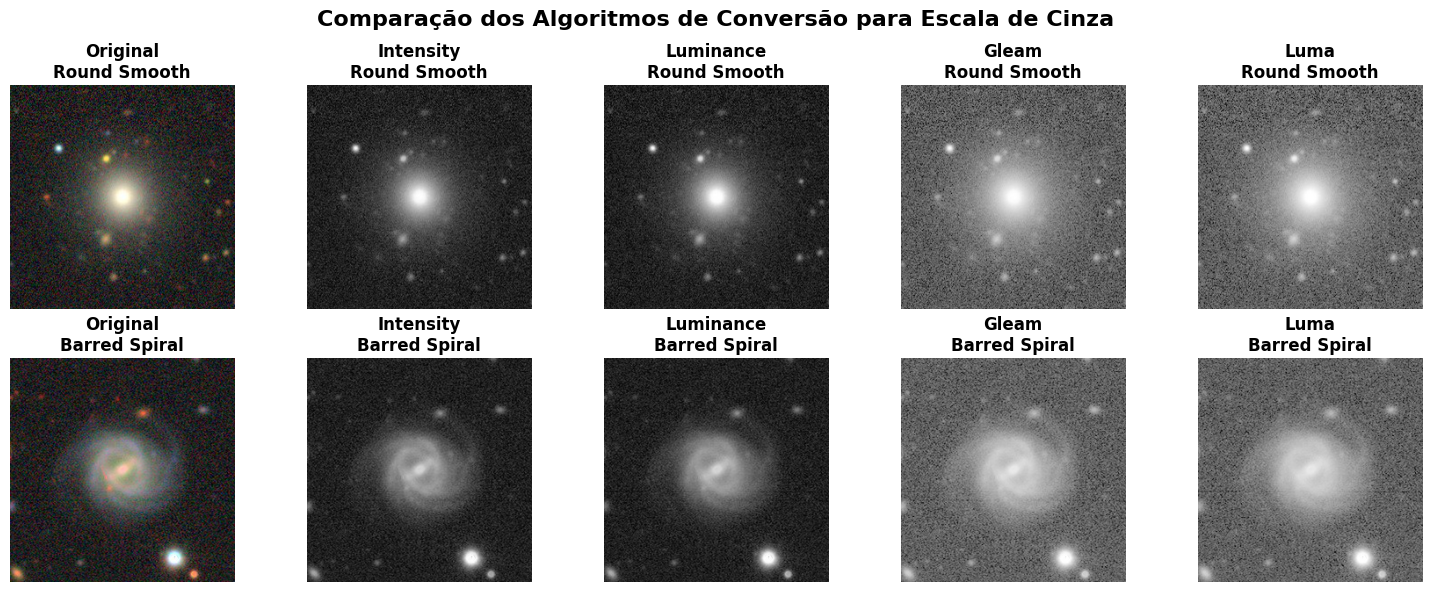

In [ ]:

view_grayscale(binary_images, binary_labels, grayscale_datasets)

In [ ]:
def create_lenet5_original(input_shape=(256, 256, 1)):
    """
    Implementação fiel da arquitetura LeNet-5 conforme artigo
    """
    model = models.Sequential([
        # Camada de entrada
        layers.Input(shape=input_shape),

        # Primeira camada convolucional - 6 filtros 5x5
        layers.Conv2D(6, (5, 5), activation='relu', padding='same', name='conv1'),
        layers.AveragePooling2D((2, 2), name='pool1'),

        # Segunda camada convolucional - 16 filtros 5x5
        layers.Conv2D(16, (5, 5), activation='relu', padding='same', name='conv2'),
        layers.AveragePooling2D((2, 2), name='pool2'),

        # Camadas fully connected
        layers.Flatten(name='flatten'),
        layers.Dense(120, activation='relu', name='dense1'),
        layers.Dense(84, activation='relu', name='dense2'),

        # Camada de saída - 2 neurônios para classificação binária
        layers.Dense(2, activation='softmax', name='output')
    ])

    return model

def create_augmentation_generator():
    """
    Data Augmentation conforme descrito no artigo:
    - Rotações
    - Flips (horizontal e vertical)
    - Zoom
    """
    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.2,
        fill_mode='nearest'
    )

In [ ]:
def prepare_data_for_training(grayscale_data, labels, test_size=0.2):
    """
    Prepara dados para treinamento com divisão 80/20
    """

    X_reshaped = grayscale_data.reshape(grayscale_data.shape + (1,))


    X_train, X_test, y_train, y_test = train_test_split(
        X_reshaped, labels, test_size=test_size, random_state=42, stratify=labels
    )

    return X_train, X_test, y_train, y_test

def train_model(X_train, y_train, X_test, y_test, algorithm_name, epochs=50):
    """
    Treina e avalia modelo para um algoritmo específico
    """
    print(f"\n{'='*50}")
    print(f"TREINANDO: {algorithm_name}")
    print(f"{'='*50}")


    model = create_lenet5_original()


    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )


    datagen = create_augmentation_generator()


    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=1
    )


    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)


    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)


    class_names = ['Round Smooth', 'Barred Spiral']
    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

    print(f"✅ {algorithm_name} - Acurácia: {test_accuracy:.3f}, Loss: {test_loss:.3f}")

    return {
        'model': model,
        'history': history,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'classification_report': report,
        'X_test': X_test
    }




In [ ]:

print("\n=== INICIANDO EXPERIMENTOS ===")

results = {}

for algorithm_name, grayscale_data in grayscale_datasets.items():

    X_train, X_test, y_train, y_test = prepare_data_for_training(grayscale_data, binary_labels)


    results[algorithm_name] = train_model(X_train, y_train, X_test, y_test, algorithm_name)

print("✅ Todos os experimentos concluídos!")

In [ ]:
def plot_training_performance(results):
    """Plota desempenho exatamente como na imagem de referência"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    algorithms = ['Intensity', 'Luminance', 'Gleam', 'Luma']


    accuracy_color = '#2E86AB'
    loss_color = '#A23B72'

    for idx, algorithm in enumerate(algorithms):
        if algorithm in results:
            history = results[algorithm]['history']

            epochs = range(1, len(history.history['accuracy']) + 1)


            ax1 = axes[idx]
            ax2 = ax1.twinx()


            ax1.plot(epochs, history.history['accuracy'],
                    color=accuracy_color, linewidth=2.5, label='Accuracy')

            # Plotar Loss (linha tracejada)
            ax2.plot(epochs, history.history['loss'],
                    color=loss_color, linewidth=2.5, linestyle='--', label='Loss')


            ax1.set_xlabel('Epochs', fontweight='bold', fontsize=10)
            ax1.set_ylabel('Accuracy', color=accuracy_color, fontweight='bold', fontsize=10)
            ax2.set_ylabel('Loss', color=loss_color, fontweight='bold', fontsize=10)


            ax1.tick_params(axis='y', labelcolor=accuracy_color)
            ax2.tick_params(axis='y', labelcolor=loss_color)


            ax1.grid(True, alpha=0.2)
            ax1.set_ylim(0, 1)


            ax1.set_title(f'{algorithm} Algorithm Training Performance',
                         fontweight='bold', fontsize=11, pad=10)


            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2,
                      loc='upper right', framealpha=0.9)



    plt.tight_layout()
    plt.show()



In [ ]:
def plot_test_results(results):
    """Plota resultados do teste conforme Tabela 1 do artigo"""
    print("\n" + "="*50)
    print("RESULTADOS DO TESTE - TABELA 1")
    print("="*50)
    print(f"{'Algoritmo':<12} {'Acurácia':<10} {'Loss':<10}")
    print("-" * 35)

    for algorithm in ['Intensity', 'Luminance', 'Gleam', 'Luma']:
        result = results[algorithm]
        print(f"{algorithm:<12} {result['test_accuracy']:.3f}     {result['test_loss']:.3f}")



In [ ]:
def plot_detailed_metrics(results):
    """Plota métricas detalhadas por classe (Tabela 2 do artigo)"""
    print("\n" + "="*60)
    print("MÉTRICAS DETALHADAS POR CLASSE - TABELA 2")
    print("="*60)

    for algorithm in ['Intensity', 'Luminance', 'Gleam', 'Luma']:
        report = results[algorithm]['classification_report']

        print(f"\n{algorithm}:")
        print(f"{'Classe':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
        print("-" * 50)

        for class_name in ['Round Smooth', 'Barred Spiral']:
            metrics = report[class_name]
            print(f"{class_name:<15} {metrics['precision']:.3f}      {metrics['recall']:.3f}       {metrics['f1-score']:.3f}")



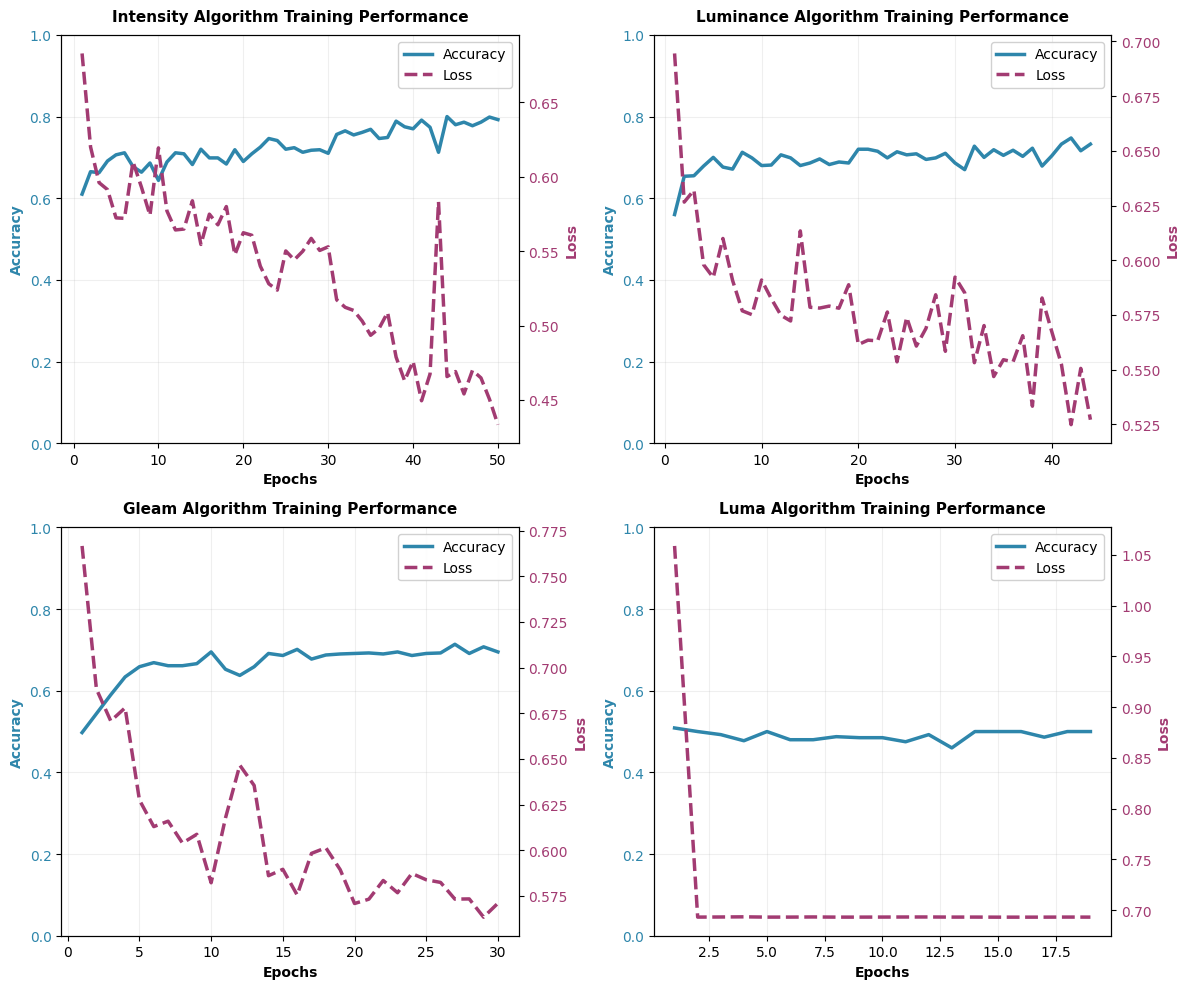

In [ ]:
plot_training_performance(results)


In [ ]:
plot_test_results(results)



RESULTADOS DO TESTE - TABELA 1
Algoritmo    Acurácia   Loss      
-----------------------------------
Intensity    0.795     0.412
Luminance    0.765     0.511
Gleam        0.780     0.512
Luma         0.500     0.693


In [ ]:
plot_detailed_metrics(results)



MÉTRICAS DETALHADAS POR CLASSE - TABELA 2

Intensity:
Classe          Precision  Recall     F1-Score  
--------------------------------------------------
Round Smooth    0.811      0.770       0.790
Barred Spiral   0.781      0.820       0.800

Luminance:
Classe          Precision  Recall     F1-Score  
--------------------------------------------------
Round Smooth    0.752      0.790       0.771
Barred Spiral   0.779      0.740       0.759

Gleam:
Classe          Precision  Recall     F1-Score  
--------------------------------------------------
Round Smooth    0.786      0.770       0.778
Barred Spiral   0.775      0.790       0.782

Luma:
Classe          Precision  Recall     F1-Score  
--------------------------------------------------
Round Smooth    0.000      0.000       0.000
Barred Spiral   0.500      1.000       0.667
